In [1]:
import matplotlib.pyplot as plt

def plot2d(data):
	data.plot(kind='scatter', x='Easting', y='Northing')

def plot3d(data, title):
	fig = plt.figure()
	ax = fig.add_subplot(projection='3d')
	ax.scatter(data['Easting'], data['Northing'], data['WaterDepth'])
	ax.set_xlabel('Easting')
	ax.set_ylabel('Northing')
	ax.set_label
	ax.set_zlabel('WaterDepth')
	ax.set_title(title)
	plt.show()

In [2]:
import pandas as pd

telemetry = pd.read_csv('./telemetry_cleaned.csv')
X = telemetry[['Easting', 'Northing', 'WaterDepth']].head(10619)

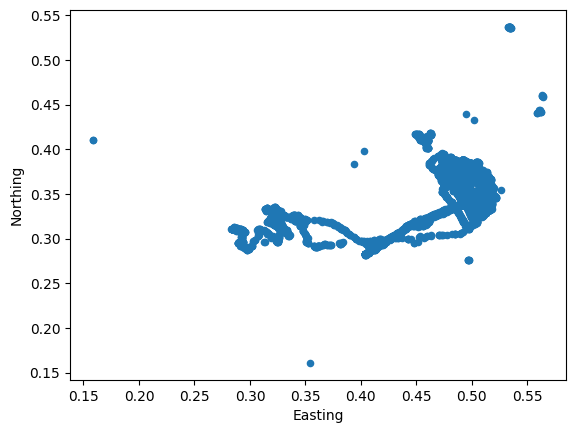

In [3]:
plot2d(X)

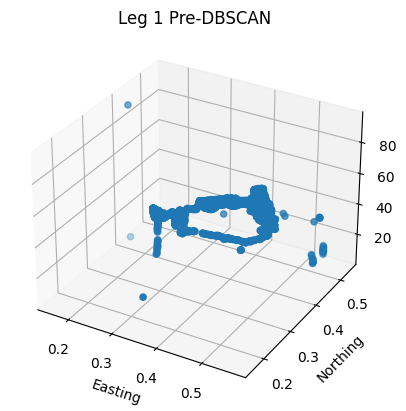

In [4]:
plot3d(X, 'Leg 1 Pre-DBSCAN')

## DBSCAN

In [17]:
def num_of_clusters(db):
	return len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

### Grid Search function

This function accepts an input dataset and a list of options. The function will iterate through each combination of these options in order to find the best results.

In [5]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import itertools

def grid_search_dbscan(data: pd.DataFrame, options: dict[str, tuple], verbose=False) -> list[dict[str, int]]:
	results = []

	# Iterate through all combinations of options
	# And perform a DBSCAN evaluation on each
	option_combs = itertools.product(*options.values())

	for eps, min_samples in list(option_combs):
		if verbose: print(f'Running eps={eps}, min_samples={min_samples}')

		db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
		labels = db.labels_

		# Get estimated number of clusters and noise points
		clusters = num_of_clusters(db)
		noise = list(labels).count(-1)

		# Silhouette Coefficient
		silhouette = metrics.silhouette_score(X, labels)

		# Davies-Bouldin Score
		davies_bouldin = metrics.davies_bouldin_score(X, labels)

		if verbose: print(f'Finished with silhouette={silhouette}')

		results.append({
			"params": { "eps": eps, "min_samples": min_samples },
			"eval": {
				"clusters": clusters,
				"noise": noise,
				"silhouette": silhouette,
				"davies_bouldin": davies_bouldin
			}
		})

	return results

### Evaluation
DBSCAN parameters based on scikit learn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

Unsupervised clustering metrics based on scikit learn [documentation](https://scikit-learn.org/stable/modules/classes.html#clustering-metrics).

In [6]:
# Run grid search with the following options
options = {
	"eps": [0.1, 0.15, 0.2, 0.3],
	"min_samples": [2, 5, 10]
}

results = grid_search_dbscan(X, options)

# Find best result
highest = 0
best = None

for res in results:
	sil = res['eval']['silhouette']

	if sil > highest:
		highest = sil
		best = res

print(f'Best result was:\n\t{best["eval"]}\nusing params:\n\t{best["params"]}')

Best result was:
	{'clusters': 11, 'noise': 185, 'silhouette': 0.6955563873811347, 'davies_bouldin': 1.112270921981551}
using params:
	{'eps': 0.15, 'min_samples': 10}


We can then use the best parameters to perform DBSCAN and apply the labels to the dataset:

In [7]:
db = DBSCAN(eps=best['params']['eps'], min_samples=best['params']['min_samples']).fit(X)
X_labeled = X.copy(deep=True)
X_labeled['Label'] = db.labels_
X_labeled.head(5)

,Easting,Northing,WaterDepth,Label
0,0.158187,0.410159,92.93,-1
1,0.158187,0.410159,5.86,-1
2,0.534407,0.535898,5.86,-1
3,0.534311,0.535924,6.33,-1
4,0.533734,0.536254,7.02,-1


We can then filter out rows with a label of -1 to denoise the dataset

In [12]:
X_denoised = X_labeled[X_labeled['Label'] != -1]
print(f'{X_labeled.shape[0] - X_denoised.shape[0]} points removed')

185 points removed


### Plot results
The following code was obtained from [scikit learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py).

In [18]:
import numpy as np

def plot_clusters(db):
	unique_labels = set(db.labels_)
	core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
	core_samples_mask[db.core_sample_indices_] = True

	colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

	for k, color in zip(unique_labels, colors):
		if k == -1:
			# Black used for noise
			color = [0, 0, 0, 1]

		class_member_mask = db.labels_ == k

		core_samples = X[class_member_mask & core_samples_mask]

		plt.plot(
			core_samples['Easting'],
			core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=10,
		)

		non_core_samples = X[class_member_mask & ~core_samples_mask]
		plt.plot(
			non_core_samples['Easting'],
			non_core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=3,
		)

	plt.title(f'Estimated clusters: {num_of_clusters(db)}')
	plt.show()

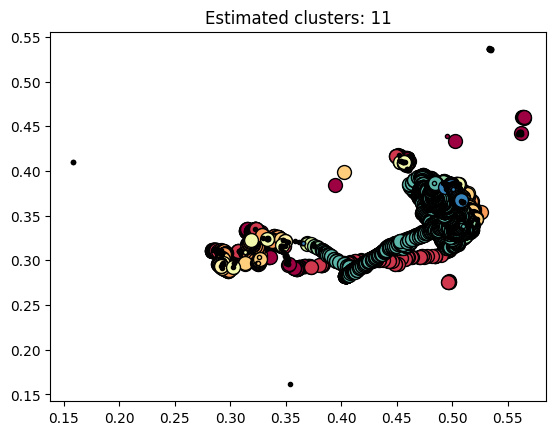

In [20]:
plot_clusters(db)

After denoised:

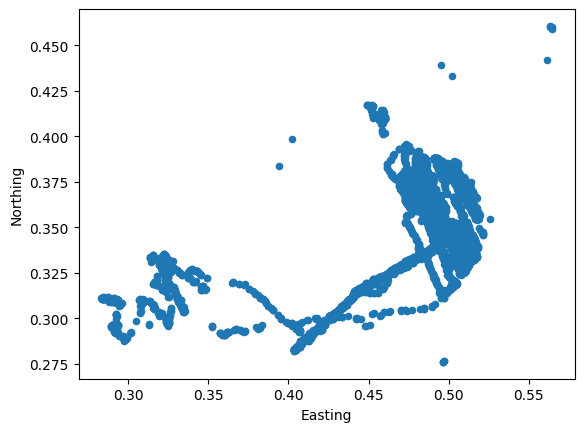

In [21]:
plot2d(X_denoised)

## Exporting Data

Finally, we can export the denoised data to CSV format to be used by the API

In [22]:
X_denoised.to_csv('../Api/src/data/telemetry_denoised.csv', index=False)